In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import mlflow
import re
import time
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from transformers import BertTokenizer, TFBertModel

import pickle


ModuleNotFoundError: No module named 'gensim'

In [2]:
mlflow.set_tracking_uri("http://mlflow-server:5000")

In [4]:
# Recharger le DataFrame depuis le fichier pickle
df_sample = pd.read_pickle('/code/df_sample.pkl')

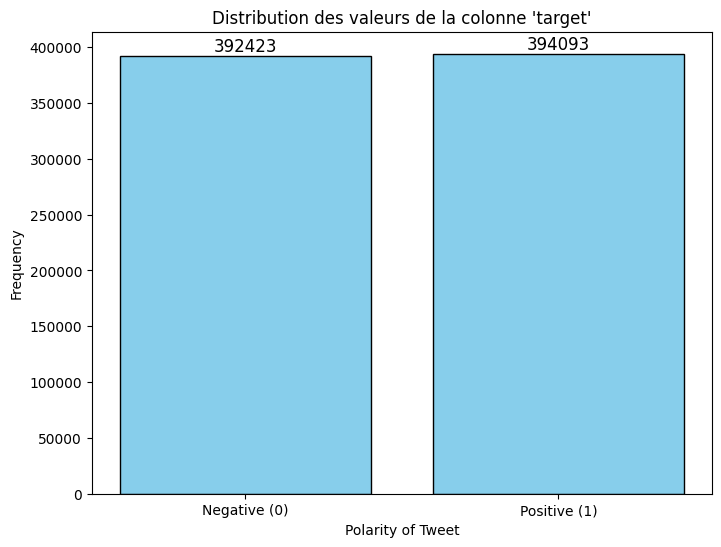

In [5]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 2, et 4
target_counts = df_sample['target'].value_counts().reindex([0, 1], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Positive (1)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/vscode-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
types_of_embeddings = ['w2v', 'glove', 'fasttext', 'bert', 'use']

In [8]:
class TweetVectorizer:
    def __init__(self, vectorizer_type='w2v', method='lemmatize'):
        self.vectorizer_type = vectorizer_type
        self.method = method
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
        # Initialiser le vectorizer
        if vectorizer_type == 'w2v':
            self.vectorizer = None  # Placeholder, Word2Vec est entraîné explicitement
        elif vectorizer_type == 'glove':
            self.glove_model = KeyedVectors.load_word2vec_format('glove.6B.100d.txt', binary=False)
        elif vectorizer_type == 'fasttext':
            self.fasttext_model = FastText(vector_size=100, window=5, min_count=1)
        elif vectorizer_type == 'bert':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.model = TFBertModel.from_pretrained('bert-base-uncased')
        elif vectorizer_type == 'use':
            self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        else:
            raise ValueError("vectorizer_type doit être 'w2v', 'glove', 'fasttext', 'bert', ou 'use'")
    
    def clean_tweet(self, tweet):
        # Convertir le tweet en minuscules
        tweet = tweet.lower()
        # Supprimer les URL commencant par 'http' ou 'https' ou 'www'
        tweet = re.sub(r'www\S+', '', tweet)
        tweet = re.sub(r'http\S+', '', tweet)
        # Supprimer les mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Supprimer les hashtags
        tweet = re.sub(r'#\w+', '', tweet)
        # Supprimer les caractères spéciaux et les chiffres
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)
        # Supprimer les espaces supplémentaires
        tweet = re.sub(r'\s+', ' ', tweet)
        return tweet
        
    def preprocess(self, tweet):
        # Supprimer les stopwords pour certains modèles d'embedding
        if self.vectorizer_type in ['w2v', 'glove', 'fasttext']:
            tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
        cleaned_tweet = self.clean_tweet(tweet)
        tokens = cleaned_tweet.split()
        
        # Appliquer le stemming ou la lemmatisation
        if self.method == 'stem':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.method == 'lemmatize':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def fit_transform(self, documents):
        # Prétraitement des documents
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            # Entraînement de Word2Vec
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'glove':
            # Utilisation de GloVe
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.glove_model[word] for word in words if word in self.glove_model] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            # Entraînement de FastText
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.fasttext_model.build_vocab(tokenized_docs, update=True)
            self.fasttext_model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=10)
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            # Utilisation de BERT
            tokenized_inputs = self.tokenizer(documents_preprocessed, return_tensors='tf', padding=True, truncation=True, max_length=128)
            outputs = self.model(tokenized_inputs)[0]
            X = np.mean(outputs, axis=1)
        elif self.vectorizer_type == 'use':
            # Utilisation de Universal Sentence Encoder
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
        
        return X
    
    def transform(self, documents):
        # Transformation des nouveaux documents en utilisant le vectorizer entraîné
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'glove':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.glove_model[word] for word in words if word in self.glove_model] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            tokenized_inputs = self.tokenizer(documents_preprocessed, return_tensors='tf', padding=True, truncation=True, max_length=128)
            outputs = self.model(tokenized_inputs)[0]
            X = np.mean(outputs, axis=1)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
        
        return X

In [ ]:
# Classe pour la classification avec régression logistique
class TweetClassifier:
    def __init__(self):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Classification", nested=True):
            mlflow.set_tag("Stage", "Classification")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Entraîner le modèle avec Cross-Validation sur le set d'entraînement
            cross_val_scores = cross_val_score(self.model, X_train, y_train, cv=5, scoring='accuracy')
            mlflow.log_metric("cross_val_accuracy_mean", cross_val_scores.mean())
            mlflow.log_metric("cross_val_accuracy_std", cross_val_scores.std())

            # Entraîner sur l'ensemble d'entraînement complet
            start_time = time.time()
            self.model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("training_time_seconds", training_time)
            
            # Évaluation sur l'ensemble de validation
            y_val_pred = self.model.predict(X_val)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            mlflow.log_metric("validation_accuracy", val_accuracy)
            mlflow.log_text(classification_report(y_val, y_val_pred), "validation_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de validation
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            roc_auc_val = auc(fpr, tpr)
            mlflow.log_metric("validation_roc_auc", roc_auc_val)
            metrics_dict = {
                "cross_val_accuracy_mean": cross_val_scores.mean(),
                "cross_val_accuracy_std": cross_val_scores.std(),
                "validation_accuracy": val_accuracy,
                "validation_roc_auc": roc_auc_val,
                "training_time_seconds": training_time
            }
            mlflow.log_table(metrics_dict, "validation_metrics_table.json")
            mlflow.set_tag("best_metric", "validation_roc_auc")
            mlflow.set_tag("validation_accuracy", val_accuracy)

            # Tracer et enregistrer la courbe ROC
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve_val.png")
            mlflow.log_artifact("roc_curve_val.png")
            plt.close()
            
            print(f"Validation Accuracy : {val_accuracy}")
            print(classification_report(y_val, y_val_pred))
    # Classe pour la classification avec régression logistique
class TweetClassifier:
    def __init__(self):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Classification", nested=True):
            mlflow.set_tag("Stage", "Classification")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Entraîner le modèle avec Cross-Validation sur le set d'entraînement
            cross_val_scores = cross_val_score(self.model, X_train, y_train, cv=5, scoring='accuracy')
            mlflow.log_metric("cross_val_accuracy_mean", cross_val_scores.mean())
            mlflow.log_metric("cross_val_accuracy_std", cross_val_scores.std())

            # Entraîner sur l'ensemble d'entraînement complet
            start_time = time.time()
            self.model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("training_time_seconds", training_time)
            
            # Évaluation sur l'ensemble de validation
            y_val_pred = self.model.predict(X_val)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            mlflow.log_metric("validation_accuracy", val_accuracy)
            mlflow.log_text(classification_report(y_val, y_val_pred), "validation_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de validation
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            roc_auc_val = auc(fpr, tpr)
            mlflow.log_metric("validation_roc_auc", roc_auc_val)
            metrics_dict = {
                "cross_val_accuracy_mean": cross_val_scores.mean(),
                "cross_val_accuracy_std": cross_val_scores.std(),
                "validation_accuracy": val_accuracy,
                "validation_roc_auc": roc_auc_val,
                "training_time_seconds": training_time
            }
            mlflow.log_table(metrics_dict, "validation_metrics_table.json")
            mlflow.set_tag("best_metric", "validation_roc_auc")
            mlflow.set_tag("validation_accuracy", val_accuracy)

            # Tracer et enregistrer la courbe ROC
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve_val.png")
            mlflow.log_artifact("roc_curve_val.png")
            plt.close()
            
            print(f"Validation Accuracy : {val_accuracy}")
            print(classification_report(y_val, y_val_pred))
    